In [88]:
# path variables
import sys
project_path = '/Users/naresh/Downloads/DS/growth/nsl_v2/nsl_v2_final/'
sys.path.insert(0, project_path+'config')
from config import SQLQuery

# core libraries
import pickle
import warnings
warnings.filterwarnings("ignore")
import datetime
import pandas as pd
import numpy as np
from datetime import date

from sklearn.preprocessing import OrdinalEncoder
from sklearn.decomposition import PCA
from xgboost import XGBClassifier, plot_importance
import matplotlib.pyplot as plt
from model_evaluations import model_metrics, cross_validation
from model_building import tune_hyperparameters

from sklearn.metrics import roc_curve, precision_recall_curve, precision_score, recall_score, roc_auc_score
from matplotlib import pyplot

In [89]:
%load_ext autoreload
%autoreload 2
from stability_monitoring import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Load data

In [90]:
# north star customers definition
txn_days = 90
txn_credit_amount = 15000

# from_date = date(2022,10,1)
# to_date = date(2023,2,28)

In [91]:
q = SQLQuery('snowflake')

In [92]:
# query to fetch the required data
df_raw_app = q("""with 

TRANSACTIONS AS -- get all credit transactions
(
    select BUSINESS_ID,
           TRANSACTION_DATE,
           AMOUNT 
  from "PROD_DB"."DATA"."TRANSACTIONS" 
  where type='credit' and status='active'
  group by 1,2,3
),

BUSINESSES as -- get all business accounts created between Oct 2022 and Feb 2023
(
  select *
  from "PROD_DB"."DATA"."BUSINESSES"
  where ACCOUNT_CREATE_DATE between '2021-07-01' and '2022-10-31'
),

ALLOY_PERSONS as -- get all the alloy persons data (max of application_versions_id in case of duplicates)
(
  select * from (
select * ,
       row_number() over (partition by APPLICATION_ID order by APPLICATION_VERSION_ID desc) as rank
from "PROD_DB"."DATA"."ALLOY_EVALUATIONS_PERSONS") 
where rank=1
),

APPLICATIONS as -- get all entries from applications table
(
  select *
  from "PROD_DB"."DATA"."APPLICATIONS"
),

BASE AS -- create base table with business and transactions
(
    select b.BUSINESS_ID,b.APPLICATION_ID,sum(t.amount) as total_credit_amount
    from BUSINESSES b 
    inner join TRANSACTIONS t
    on b.BUSINESS_ID=t.BUSINESS_ID
    where DATEDIFF(day, ACCOUNT_CREATE_DATE, TRANSACTION_DATE) between 0 AND """ + str(txn_days) + """
    group by 1,2
)

    select B.business_id, 
    coalesce(total_credit_amount,0) as total_deposit, 
    A.*, P.*
    from BUSINESSES B
    left join base
    on B.business_id = base.business_id
    left join APPLICATIONS A
    on B.application_id = A.application_id
    left join ALLOY_PERSONS P
    on B.application_id = P.application_id
    """)

df_raw_app.shape

(127513, 163)

In [93]:
# drop null application ids
df_raw_app = df_raw_app.dropna(subset='application_id')

# tag north star customers
df_raw_app['ns_flag'] = np.where(df_raw_app['total_deposit']>=txn_credit_amount, 1, 0)

# get non-ns vs ns accounts split
df_raw_app['ns_flag'].value_counts(dropna=False)

0    118856
1      8654
Name: ns_flag, dtype: int64

In [94]:
# drop duplicate columns
df_raw_app = df_raw_app.loc[:,~df_raw_app.columns.duplicated()].copy()
df_raw_app.shape

(127510, 162)

In [95]:
print('Applications with $0 deposit:', df_raw_app[df_raw_app['total_deposit'] == 0].shape[0])
print('Applications with deposit less than 5K :', df_raw_app[(df_raw_app['total_deposit'] <= 5000)].shape[0])
print('Applications with $15K deposit or more:', df_raw_app[df_raw_app['total_deposit'] >= txn_credit_amount].shape[0])
print('Applications with deposit between $0 and $15K :', df_raw_app[(df_raw_app['total_deposit'] > 0) & (df_raw_app['total_deposit'] < txn_credit_amount)].shape[0])


Applications with $0 deposit: 41475
Applications with deposit less than 5K : 107634
Applications with $15K deposit or more: 8654
Applications with deposit between $0 and $15K : 77381


In [118]:
# # raw data
# file = 'app_scoring_dataset_train_test.pkl'
# path = project_path + 'data/'
# df_raw_app.reset_index(inplace=True)
# df_raw_app.to_pickle(path+file)


In [119]:
segment_raw_data = q(
"""
with 
BUSINESS_DETAIL as -- get all business accounts created between Oct 2022 and Feb 2023
(
  select a.*
  from "PROD_DB"."DATA"."BUSINESSES" a
  inner join
  "PROD_DB"."DATA"."APPLICATIONS" b
  on a.application_id=b.application_id
  where 1=1 
        and date(a.ACCOUNT_CREATE_DATE) between '2021-07-01' and '2022-10-31'

)

,segment_all as (
select b.application_id, a.USER_ID, a.anonymous_id, a.CONTEXT_IP, a.OWNER_ID, context_page_path, screen_width, screen_height, timezone, sent_at, received_at
from BUSINESS_DETAIL b
left join SEGMENT_DB.ONBOARDING_PROD.PAGES a
on a.application_id=b.application_id
order by a.application_id, received_at asc
)

-- Pull all the records which crossed the 13th question  
,segment_till_incoming as (select a.application_id, a.context_page_path, a.received_at from 
(select a.application_id, a.context_page_path, a.received_at, rank() over(partition by a.application_id order by a.received_at asc) as rk
from segment_all a
where a.context_page_path='/app/business-questions/incoming'
) a where rk=1 )

-- Pull customer visited pages till the 13th question
,final as (select
a.application_id, a.USER_ID, a.anonymous_id, a.CONTEXT_IP, a.OWNER_ID, a.context_page_path, a.screen_width, a.screen_height, a.timezone, a.sent_at, a.received_at 
from segment_all a
inner join segment_till_incoming b
on a.application_id=b.application_id and a.received_at <= b.received_at
order by a.application_id, a.received_at asc
)

select * from final order by application_id, received_at asc

"""
)


In [120]:
def segment_features_1(df:pd.DataFrame, cols_list:list, app_level_df:pd.DataFrame, training:bool=True):
    """ 
        df : segment raw data
        cols_list: columns list on which the operations are performed
        app_level_df: application level data
        
    """
    
    new_cols = []
    for col in cols_list:
        tmp = df[['application_id',col]].drop_duplicates(subset=['application_id',col], keep='first')
        tmp2 = pd.DataFrame(tmp.application_id.value_counts()).reset_index()
        col = col+'_count'
        tmp2.rename(columns={'application_id':col, 'index':'application_id'}, inplace=True)
    
        # Merging with app level df
        app_level_df = pd.merge(app_level_df, tmp2, on='application_id', how='left')
        new_cols.append(col)
        
    if training:
        df_impute_segment = app_level_df[new_cols].median()
        df_impute_segment = pd.DataFrame(df_impute_segment, columns=['impute_value']).reset_index().rename(columns={'index':'feature'})
        df_impute_segment.to_pickle(project_path+'models/df_impute_segment.pkl') # Save the impute values as df

    else:
        df_impute_segment = pd.read_pickle(project_path+'models/df_impute_segment.pkl') # Load the impute values as df

    # screen height and width features
    tmp2 = pd.DataFrame()
    tmp2 = pd.concat([tmp2, df[['application_id','screen_height','screen_width']]])
    tmp2.drop_duplicates(subset=['application_id','screen_height','screen_width'],keep='first', inplace=True)

    new_cols2 = []
    list_value_type = ['max','min','mean','median']
    for value_type in list_value_type:
        colw = 'screen_width'
        tmp = pd.DataFrame(tmp2.groupby(['application_id'])[colw].agg([value_type]))
        tmp[value_type] = tmp[value_type].astype('float')
        tmp.rename(columns={value_type:colw+'_'+value_type}, inplace=True) 
        app_level_df = pd.merge(app_level_df, tmp, on='application_id', how='left')
        
        new_cols2.append(colw+'_'+value_type)

        colh = 'screen_height'
        tmp = pd.DataFrame(tmp2.groupby(['application_id'])[colh].agg([value_type]))
        tmp[value_type] = tmp[value_type].astype('float')
        tmp.rename(columns={value_type:colh+'_'+value_type}, inplace=True) 
        app_level_df = pd.merge(app_level_df, tmp, on='application_id', how='left')
        
        new_cols2.append(colh+'_'+value_type)
        
    if training:
        df_impute_segment2 = app_level_df[new_cols2].median()
        df_impute_segment2 = pd.DataFrame(df_impute_segment2, columns=['impute_value']).reset_index().rename(columns={'index':'feature'})
        df_impute_segment2.to_pickle(project_path+'models/df_impute_segment2.pkl') # Save the impute values as df

    else:
        df_impute_segment2 = pd.read_pickle(project_path+'models/df_impute_segment2.pkl') # Load the impute values as df

    return app_level_df


In [121]:
def segment_features_2(df:pd.DataFrame, app_level_df:pd.DataFrame, training:bool=True):
    """ 
        df : segment raw data
        cols_list: columns list on which the operations are performed
        app_level_df: application level data
        
    """
    # Cleaning the list of owner_ids
    def clean_string(x):
        if x != None:
            x = str(x)
            x = [val.strip("""'|[| |"|,|]""") for val in x.split('/') if not val.strip("""'|[| |"|,|]""") in ['',None] and len(val.strip("""'|[| |"|,|]"""))<36]
        return '/'.join(x)

    df['context_page_path_clean'] = df['context_page_path'].apply(clean_string)
    # One-hot encoding the unique page paths
    col = 'context_page_path_clean'
    tmp = df[col].str.get_dummies()
    tmp['application_id'] = df.application_id
    # Common pages that every applicant must visit
    common_pages = ['verify-email-otp','welcome','app/applicant/personal-info','app/applicant/phone'
    ,'app/applicant/otp-verify','app/applicant/address','app/applicant/dob-ssn','app/business/business-type'
    ,'app/business/address','app/business/other-info','app/business-questions/about-business'
    ,'app/business-questions/incoming']

    # no.of visits per page
    tmp2 = tmp[common_pages+['application_id']].groupby(['application_id']).sum()
    tmp2.reset_index(drop=False, inplace=True)
    tmp2 = pd.merge(app_level_df, tmp2, on='application_id', how='left')
    
    # no.of unique pages per user
    tmp3 = tmp.groupby(['application_id']).sum()
    tmp3.reset_index(drop=False, inplace=True)
    tmp3 = pd.merge(tmp3, app_level_df[['application_id']], on='application_id', how='left')
    drop_cols = ['404','app/applicant','app/business','application-denied','forgot-password','signup','status','undefined']
    drop_cols = [col for col in tmp3.columns.to_list() if col in drop_cols]
    tmp3 = tmp3.drop(columns=drop_cols)
    tmp3 = tmp3.dropna(subset=['application_id'])
    
    tmp4 = pd.DataFrame()
    tmp4['application_id'] = tmp3.application_id
    cols = tmp3.drop(columns=['application_id']).columns.to_list()
    tmp4[cols] = pd.DataFrame(np.where(tmp3[cols]>=1, 1, 0))
    tmp4 = tmp4.set_index('application_id')
    tmp4 = pd.DataFrame(tmp4.sum(axis=1), columns=['page_count'])
    tmp2 = pd.merge(tmp2,tmp4,on='application_id',how='left')

    if training:
        df_impute_segment3 = tmp2[common_pages+['page_count']].median()
        df_impute_segment3 = pd.DataFrame(df_impute_segment3, columns=['impute_value']).reset_index().rename(columns={'index':'feature'})
        df_impute_segment3.to_pickle(project_path+'models/df_impute_segment3.pkl') # Save the impute values as df

    else:
        df_impute_segment3 = pd.read_pickle(project_path+'models/df_impute_segment3.pkl') # Load the impute values as df

    return tmp2


In [122]:
def segment_features_3(app_level_df:pd.DataFrame):
    """ 
        df : segment raw data
        cols_list: columns list on which the operations are performed
        app_level_df: application level data
        
    """
    impute1 = pd.read_pickle(project_path+'models/df_impute_segment.pkl')
    impute2 = pd.read_pickle(project_path+'models/df_impute_segment2.pkl')
    impute3 = pd.read_pickle(project_path+'models/df_impute_segment3.pkl')
    
    ############# PART-1 #############
    # Function to fill nulls with median values
    def fill_null_values(df_impute:pd.DataFrame, data_df:pd.DataFrame,):
        df_dict = dict(df_impute.values)
        impute_cols = df_impute['feature'].to_list()
        for col in data_df.columns.to_list():
            if col in impute_cols:
                data_df[col] = data_df[col].fillna(df_dict[col])
                impute_cols.remove(col)
        return data_df

    # Filling nulls with median
    app_level_df = fill_null_values(impute1, app_level_df)
    app_level_df['sh_sw_ratio_count'] = app_level_df['screen_height_count']/app_level_df['screen_width_count']
    app_level_df['sh_sw_ratio_count'] = app_level_df['sh_sw_ratio_count'].astype('float')
    
    cols_list_1 = impute1.feature.to_list()
    # Feature Engg
    for col in cols_list_1:
        app_level_df[col] = np.where(app_level_df[col]==1,1,0)
        

    ############# PART-2 #############
    # Filling nulls with median
    app_level_df = fill_null_values(impute2, app_level_df)

    # Function to fill zero screen width and height with median values
    def fill_zero_values(df_impute:pd.DataFrame, data_df:pd.DataFrame,):
        df_dict = dict(df_impute.values)
        impute_cols = df_impute['feature'].to_list()
        for col in data_df.columns.to_list():
            if col in impute_cols:
                data_df[col] = np.where(data_df[col]==0, df_dict[col], data_df[col])
                impute_cols.remove(col)
        return data_df
    
    # Filling zeros with median
    app_level_df = fill_zero_values(impute2, app_level_df)
    # Creating Ratios
    list_value_type = ['max','min','mean','median']
    for value_type in list_value_type:
        colh = 'screen_height'
        colw = 'screen_width'
        app_level_df['sh_sw_ratio_'+value_type] = app_level_df[colh+'_'+value_type]/app_level_df[colw+'_'+value_type]

    
    ############# PART-3 #############
    cols_list_3 = impute3.feature.to_list()
    app_level_df = fill_null_values(impute3, app_level_df)
    
    return app_level_df

In [123]:

segment_pages_oot = segment_raw_data.copy()
# Filter only the existing applications in segment data
segment_pages_oot = segment_pages_oot[~segment_pages_oot.received_at.isnull()]
segment_pages_oot.reset_index(drop=True, inplace=True)
segment_pages_oot = segment_pages_oot.sort_values(by=['application_id','received_at'])

# Change data type
cols = ['application_id','user_id','owner_id','anonymous_id','context_page_path','timezone']
segment_pages_oot[cols] = segment_pages_oot[cols].astype('string')
segment_pages_oot[['screen_width','screen_height']] = segment_pages_oot[['screen_width','screen_height']].astype('int')

for col in segment_pages_oot.columns:
    if col != 'user_id':
        idx = segment_pages_oot.index[segment_pages_oot[col].isnull()].tolist()
        idx.extend(segment_pages_oot.index[segment_pages_oot[col].isna()].tolist())
        idx.extend(segment_pages_oot.index[segment_pages_oot[col] == ''].tolist())
        idx.extend(segment_pages_oot.index[segment_pages_oot[col] == '[]'].tolist())
        idx = list(set(idx))
        segment_pages_oot.loc[idx, col] = None    


df_oot = df_raw_app.copy()

df_oot_tmp = pd.merge(segment_pages_oot, df_oot[['application_id', 'ns_flag']], on='application_id', how='inner')
x_oot = df_oot_tmp.reset_index(drop=True)

cols_list = ['timezone','user_id','owner_id','anonymous_id','context_ip','screen_width','screen_height']
# Creating df with all apps
app_level_data = pd.DataFrame()
app_level_data['application_id'] = x_oot.application_id.unique()

app_level_data = segment_features_1(df=x_oot, cols_list=cols_list, app_level_df=app_level_data, training=False)
app_level_data = segment_features_2(df=x_oot, app_level_df=app_level_data, training=False)

df_oot = pd.merge(df_oot[['application_id', 'ns_flag']], app_level_data, on='application_id', how='left')
x_oot = df_oot.reset_index(drop=True)
y_oot = x_oot['ns_flag']
app_level_data_oot = segment_features_3(app_level_df=x_oot)


In [124]:
# # save the oot dataset
# file = 'segment_scoring_dataset_train_test.pkl'
# path = project_path + 'data/'
# app_level_data_oot.reset_index(inplace=True)
# app_level_data_oot.to_pickle(path+file)

In [126]:
# train test flag
file = 'nsl_train_test_flag_2023-05-30.pkl'
path = project_path + 'data/'
df_train_test = pd.read_pickle(path + file)
df_train_test.shape

(124703, 6)

In [137]:

df = pd.merge(df_raw_app, df_train_test[['application_id', 'train_flag', 'test_flag']], on='application_id', how='inner')

#### TRAIN DATA #####
x_train = df[df['train_flag'] == 1].reset_index(drop=True)
x_train = x_train[~((x_train.total_deposit>10000) & (x_train.ns_flag==0))].reset_index(drop=True)
x_train = pd.merge(x_train, app_level_data_oot.drop(columns=['ns_flag','index']), on='application_id', how='inner')
y_train = x_train['ns_flag']

#### TEST DATA #####
x_test = df[df['test_flag'] == 1].reset_index(drop=True)
# Adding segment test data
# segment_test = pd.read_pickle(project_path+'data/segment_processed_data_test.pkl')
x_test = pd.merge(x_test, app_level_data_oot.drop(columns=['ns_flag','index']), on='application_id', how='inner')
y_test = x_test['ns_flag']


#### Feature creation

In [128]:
def convert_nulls_to_one_format(df:pd.DataFrame):
    for col in df.columns:
        idx = df.index[df[col].isnull()].tolist()
        idx.extend(df.index[df[col].isna()].tolist())
        idx.extend(df.index[df[col] == ''].tolist())
        idx.extend(df.index[df[col] == '[]'].tolist())
        idx = list(set(idx))
        df.loc[idx, col] = None
    return df


def fill_null_values(df_impute:pd.DataFrame, data_df:pd.DataFrame,):
    df_dict = dict(df_impute.values)
    impute_cols = df_impute['feature'].to_list()
    for col in data_df.columns.to_list():
        if col in impute_cols:
            data_df[col] = data_df[col].fillna(df_dict[col])
            impute_cols.remove(col)
    return data_df

In [129]:
def feature_engineering_alloy(df:pd.DataFrame, training:bool=True):
    
    # feature 1
    col = 'iovation_device_type'
    df[col] = df[col].str.lower()
    df[col] = np.where(df[col].isin(['windows','iphone','mac','android']),df[col],'other')
        
    # feature 2
    df['line_type'] = df['line_type'].str.lower()
    df['line_type'] = np.where(df['line_type']=='mobile', 'mobile', 'other')

    # feature 3
    df['iovation_device_timezone'] = np.where(df['iovation_device_timezone'].isin(['300','360','480']),
                                                   df['iovation_device_timezone'], 'other')
    # feature 4 
    col = 'iovation_device_ip_isp'
    df[col] = df[col].str.lower()
    df[col] = np.where(df[col].str.contains('verizon'),'verizon',df[col])
    df[col] = np.where(df[col].str.contains('at&t'),'att',df[col])
    df[col] = np.where(df[col].str.match('att'),'att',df[col])
    df[col] = np.where(df[col].str.match('charter [b|c]'),'charter',df[col])
    df[col] = np.where(df[col].str.match('comcast'),'comcast',df[col])
    df[col] = np.where(df[col].isin(['att','charter','verizon','comcast']),df[col],'other')
    
    # feature 5 
    col = 'iovation_device_ip_org'
    df[col] = df[col].str.lower()
    df[col] = np.where(df[col].str.contains('verizon'),'verizon',df[col])
    df[col] = np.where(df[col].str.contains('at&t'),'att',df[col])
    df[col] = np.where(df[col].str.match('att'),'att',df[col])
    df[col] = np.where(df[col].str.match('charter [b|c]'),'charter',df[col])
    df[col] = np.where(df[col].str.match('comcast'),'comcast',df[col])
    df[col] = np.where(df[col].isin(['att','charter','verizon','comcast']),df[col],'other')
    
    # feature 6 
    col = 'carrier'
    df[col] = df[col].str.lower()
    df[col] = np.where(df[col].str.contains('verizon'),'verizon',df[col])
    df[col] = np.where(df[col].str.contains('at&t'),'att',df[col])
    df[col] = np.where(df[col].str.match('att'),'att',df[col])
    df[col] = np.where(df[col].str.contains('t-mobile*'),'tmobile',df[col])
    df[col] = np.where(df[col].isin(['att','tmobile','verizon']),df[col],'other')
    
#     # feature 7 
#     col = 'iovation_device_ip_region'
#     df[col] = df[col].str.lower()
#     # Bucketing into low and high deposit categories
#     high_ns_region = pd.read_pickle(project_path+'models/high_ns_region.pkl')[col].to_list()
#     low_ns_region = pd.read_pickle(project_path+'models/low_ns_region.pkl')[col].to_list()
#     df[col] = np.where(df[col].isin(high_ns_region),'high_ns',df[col])
#     df[col] = np.where(df[col].isin(low_ns_region),'low_ns',df[col])
#     df[col] = np.where(df[col].isin(['high_ns','low_ns']),df[col],'other')
    
#     # feature 8
#     col = 'iovation_device_ip_city'
#     df[col] = df[col].str.lower()
#     # Bucketing into low and high deposit categories
#     high_ns_city = pd.read_pickle(project_path+'models/high_ns_city.pkl')[col].to_list()
#     low_ns_city = pd.read_pickle(project_path+'models/low_ns_city.pkl')[col].to_list()
#     df[col] = np.where(df[col].isin(high_ns_city),'high_ns',df[col])
#     df[col] = np.where(df[col].isin(low_ns_city),'low_ns',df[col])
#     df[col] = np.where(df[col].isin(['high_ns','low_ns']),df[col],'other')

    # IDA reason codes
    ida_reason_codes_columns = pd.read_pickle(project_path+'models/ida_reason_codes_columns.pkl')
    df_tmp2 = pd.DataFrame(index=range(df.shape[0]),columns=ida_reason_codes_columns['feature'].to_list())
    df_tmp2 = df_tmp2.fillna(0)

    col = 'ida_score_reason_1'
    df_tmp = pd.get_dummies(df[col].astype('int'), prefix=col)
    col = 'ida_score_reason_2'
    df_tmp = pd.concat([df_tmp, pd.get_dummies(df[col].astype('int'), prefix=col)], axis=1)
    col = 'ida_score_reason_3'
    df_tmp = pd.concat([df_tmp, pd.get_dummies(df[col].astype('int'), prefix=col)], axis=1)    
    
    df_tmp2.update(df_tmp)
    df_tmp2 = df_tmp2.astype('int')
    df = pd.concat([df,df_tmp2], axis=1)

    # Socure reason codes
    # Cleaning the list of reason codes
    def clean_string(x):
        if x != None:
            x = [val.strip("""'|[| |"|,|]""") for val in x.split('\n') if not val.strip("""'|[| |"|,|]""") in ['',None]]
        return x

    socure_cols = ['socure_phonerisk_reason_code','socure_addressrisk_reason_code','socure_emailrisk_reason_code'
                  ,'socure_reason_code']
    df_socure = df[socure_cols]

    # Collecting the cleaned reason codes
    for col in socure_cols:
        df_socure[col] = df_socure[col].astype('str')
        df_socure[col] = df_socure[col].str.lower()
        df_socure[col] = df_socure[col].apply(clean_string)
        
    socure_cols = ['socure_phonerisk_reason_code','socure_addressrisk_reason_code','socure_emailrisk_reason_code'
                  ,'socure_reason_code']
    dict_cols = {}
    for col in socure_cols:
        df_socure = df_socure.drop(col, 1).join(df_socure[col].str.join('|').str.get_dummies())
        socure_cols = df_socure.columns[df_socure.columns.str.startswith('socure')].to_list()
        true_cols = list(set(df_socure.columns.to_list()) - set(socure_cols))
        new_cols = []
        for col2 in true_cols:
            new_cols.append(col+'_'+col2)
        dict_cols = dict(zip(true_cols, new_cols)) | dict_cols
        df_socure.rename(columns=dict_cols, inplace=True)

    df_socure = df_socure.T
    df_socure = df_socure[~df_socure.index.duplicated(keep='first')].T
    df_socure = df_socure.astype('int')
        
    socure_reason_codes_columns = pd.read_pickle(project_path+'models/socure_reason_codes_columns.pkl')
    df_tmp = pd.DataFrame(index=range(df.shape[0]),columns=socure_reason_codes_columns['feature'].to_list())
    df_tmp = df_tmp.fillna(0)
    
    df_tmp.update(df_socure)
    df_tmp = df_tmp.astype('int')
    df = pd.concat([df,df_tmp], axis=1)
    
    return df


In [130]:
def feature_engineering_app(df:pd.DataFrame):
    # business type
    df['business_group'] = np.where(df['business_type'] == 'sole_proprietorship', 0, 1)

    # email domain
    df['email_domain_bucket'] = np.where(df['email_domain'].isin(
                                    list(df.groupby("email_domain").filter(lambda x: (len(x) >= 10))['email_domain'].unique())), 0, 1)

    # estimated business numbers
    estimated_cols = ['estimated_monthly_revenue',
                      'incoming_ach_payments',
                      'check_deposit_amount',
                      'incoming_wire_transfer',
                      'outgoing_ach_and_checks',
                      'outgoing_wire_transfers']

    # grouping all responses into 5K+ and 5K-
    for col in estimated_cols:
        df[col] = df[col].str.lower()
        df[col] = np.where(df[col].isin(['$5k +', '$50k +']), 1, 0)

    # number of employees
    df["number_of_employees"] = pd.to_numeric(df["number_of_employees"])
    df['number_of_employees_bin'] = df["number_of_employees"]
    df['number_of_employees_bin'] = np.where((df['number_of_employees']>=2) & (df['number_of_employees']<=5), 2, 
                                    np.where((df['number_of_employees']>5), 3, 1))
    df['number_of_employees_bin'].value_counts()

    # purpose of account - options selected
    df['purpose_of_account_options_selected'] = df['purpose_of_account'].str.count(',')+1
    df['purpose_of_account_options_selected'] = np.where(df['purpose_of_account_options_selected']<=3, 0, 1)

#     # industry type
#     hdi_group = pd.read_pickle(project_path+'models/hdi_group.pkl')['value'].to_list()

#     df['industry_group'] = np.where(df['industry_category_name'].isin(hdi_group), 1, 0)
#     df['industry_group'].value_counts()

    # business age
    df['date_of_establishment_dt'] = pd.to_datetime(df['date_of_establishment'], format='%Y-%m', errors='coerce').dropna()
    df['business_age'] = round((df['application_start_datetime'] - df['date_of_establishment_dt']) / np.timedelta64(1, 'Y'),2)
    df['business_age'] = df['business_age'].fillna(0)
    df['business_age_bucket'] = np.where(df['business_age'] <= 1, 1, 
                                        np.where((df['business_age']>1) & (df['business_age']<=3), 2, 3))
    df['business_age_bucket'].value_counts().sort_values()

    # website flag
    df['website_flag'] = np.where(df['website'].isna(), 0, 1)

#     # state
#     hds = pd.read_pickle(project_path+'models/high_ns_busi_state.pkl')['business_address_state'].to_list()
#     lds = pd.read_pickle(project_path+'models/low_ns_busi_state.pkl')['business_address_state'].to_list()        
#     df['business_address_state'] = np.where(df['business_address_state'].isin(hds), 'high_ns', 
#                                            np.where(df['business_address_state'].isin(lds), 'low_ns', 'other'))

#     # city
#     hdc = pd.read_pickle(project_path+'models/high_ns_busi_city.pkl')['business_address_city'].to_list()
#     ldc = pd.read_pickle(project_path+'models/low_ns_busi_city.pkl')['business_address_city'].to_list()
#     df['business_address_city'] = np.where(df['business_address_city'].isin(hdc), 'high_ns', 
#                                        np.where(df['business_address_city'].isin(ldc), 'low_ns', 'other'))    
    
    # current bank
    hdb_group = ['bluevine', 'other-national-bank', 'td-ank', 'chase', 'usaa']
    df['current_bank_group'] = np.where(df['current_bank'].isin(hdb_group), 1, 0)

    # website similar to email domain
    df['website_processed'] = df['website'].fillna('')
    df['website_email_domain_match'] = df.apply(lambda x: x.email_domain in x.website_processed, axis=1)
    df['website_email_domain_match'] = np.where(df['website_email_domain_match']==True, 1, 0)

    # ein_ssn
    df['ein_ssn'] = np.where(df['ein_ssn']=='1', 1, 0)

#     # business pitch
#     bag_of_words = pd.read_pickle(project_path+'models/business_pitch_bow.pkl')['bow'].to_list()
#     df['bow_flag'] = np.where(df['business_pitch_lema_spacy'].str.contains('|'.join(bag_of_words)), 1, 0)
    
    return df
    

#### Filter for raw features

In [131]:
raw_features_app = [
 'application_start_datetime',
 'email_domain',
 'estimated_monthly_revenue',
 'incoming_ach_payments',
 'check_deposit_amount',
 'incoming_wire_transfer',
 'outgoing_ach_and_checks',
 'outgoing_wire_transfers',
 'number_of_employees',
 'purpose_of_account',
 'current_bank',
 'industry_category_name',
 'date_of_establishment',
 'business_type',
 'website',
 'business_address_city',
 'business_address_state',
 'ein_ssn'
#  'business_pitch_lema_spacy'
]

# Alloy Features
# Numerical
num_cols = ['socure_emailrisk', 'socure_phonerisk', 'socure_addressrisk','socure_sigma','sentilink_abuse_score'
            ,'sentilink_first_party_synthetic_score','sentilink_third_party_synthetic_score','person_score'
            ,'ida_score']
# Categorical
cat_columns = ['iovation_device_type','iovation_device_timezone','iovation_device_ip_isp'
               ,'iovation_device_ip_city','iovation_device_ip_region'
               ,'iovation_device_ip_org'
               ,'carrier','line_type']
# Reason codes - IDA
ida_reason_cols = ['ida_score_reason_1','ida_score_reason_2','ida_score_reason_3']
# Reason codes - Socure
socure_reason_cols = ['socure_reason_code','socure_emailrisk_reason_code','socure_phonerisk_reason_code'
                      ,'socure_addressrisk_reason_code']

raw_features_segment = app_level_data_oot.drop(columns=['application_id','ns_flag','index']
                                         ).columns.to_list()

In [132]:
raw_features_alloy = num_cols + cat_columns + ida_reason_cols + socure_reason_cols
raw_features = raw_features_app + raw_features_alloy + raw_features_segment

#### Independent variables

In [133]:
independent_features_app = ['estimated_monthly_revenue', 
                        'incoming_ach_payments', 
                        'check_deposit_amount', 
                        'incoming_wire_transfer',
                        'outgoing_ach_and_checks', 
                        'outgoing_wire_transfers',
                        'ein_ssn',
                        'business_group', 
                        'email_domain_bucket', 
                        'number_of_employees_bin',
                        'purpose_of_account_options_selected', 
                        'industry_category_name',
                        'business_age_bucket',
                        'website_flag', 
                        'business_address_state', 
                        'business_address_city', 
                        'current_bank_group',
                        'website_email_domain_match'
                           ]

# Alloy Features
ida_reason_codes_columns = pd.read_pickle(project_path+'models/ida_reason_codes_columns.pkl')['feature'].to_list()
socure_reason_codes_columns = pd.read_pickle(project_path+'models/socure_reason_codes_columns.pkl'
                                            )['feature'].to_list()

reason_codes_cols = ida_reason_codes_columns + socure_reason_codes_columns
# Final alloy columns
independent_features_alloy_tmp = num_cols + cat_columns + reason_codes_cols
independent_features_alloy_tmp = [val for val in independent_features_alloy_tmp if val not in 
                                  ['iovation_device_ip_region','iovation_device_ip_city']]


#### Fit model

In [182]:
file_name = "nsql_model_v2.pkl"
path = project_path + 'models/'
xgb_model = pickle.load(open(path+file_name, "rb"))

top_features = [
    'estimated_monthly_revenue', 'incoming_ach_payments',
       'screen_width_mean', 'sh_sw_ratio_mean',
       'socure_emailrisk_reason_code_i553', 'iovation_device_type_mac',
       'industry_category_name_professional, scientific, and technical services',
       'outgoing_ach_and_checks', 'business_group', 'socure_sigma',
       'industry_category_name_real estate rental and leasing',
       'industry_category_name_retail trade', 'socure_emailrisk',
       'iovation_device_type_android', 'check_deposit_amount',
       'socure_emailrisk_reason_code_i566',
       'socure_phonerisk_reason_code_i630', 'socure_phonerisk',
       'outgoing_wire_transfers', 'socure_emailrisk_reason_code_r561',
       'socure_reason_code_r207', 'iovation_device_timezone_480',
       'socure_phonerisk_reason_code_i614',
       'socure_emailrisk_reason_code_i555',
       'industry_category_name_manufacturing'
]


### Train Data

In [178]:
oot_df = x_train.copy()
y_oot = y_train.copy()

# Adding segment test data
segment_oot = app_level_data_oot.copy()
# oot_df = pd.merge(oot_df, segment_oot, on='application_id', how='inner')
x_oot = oot_df[raw_features]

# convert all string features to lowercase
string_features = ['email_domain',
 'purpose_of_account',
 'current_bank',
 'industry_category_name',
 'business_type',
 'business_address_city',
 'business_address_state',
 'website']+cat_columns+socure_reason_cols

for col in string_features:
    x_oot[col] = x_oot[col].str.lower()

In [179]:
x_oot.shape, y_oot.shape

((84789, 75), (84789,))

In [180]:
x_oot = convert_nulls_to_one_format(df=x_oot)
df_impute = pd.read_pickle(project_path+'models/df_impute.pkl')
x_oot = fill_null_values(df_impute, x_oot)

x_oot = feature_engineering_app(df=x_oot)
x_oot = feature_engineering_alloy(df=x_oot, training=False)

# Removing reason code features as these are already encoded
x_oot.drop(columns=ida_reason_cols+socure_reason_cols, inplace=True)

# Encoding the categories
x_object_cols = x_oot[independent_features_alloy_tmp].select_dtypes(include=['object']).columns.to_list()
x_object_cols = x_object_cols+['industry_category_name']

x_object_onehot = pd.get_dummies(x_oot[x_object_cols]) # create dummies
x_object_onehot = x_object_onehot.astype('int')
x_oot = pd.concat([x_oot.drop(columns=x_object_cols), x_object_onehot], axis=1)
x_oot.columns= x_oot.columns.str.lower() # convert column names to lower case


# Filter the final independent features
train_cols = pd.read_pickle(project_path+'models/train_data_columns.pkl')['feature'].to_list()
df_tmp = pd.DataFrame(index=range(x_oot.shape[0]),columns=train_cols)
df_tmp = df_tmp.fillna(0)
df_tmp.update(x_oot)
x_oot = df_tmp.copy()
x_oot.shape

(84789, 400)

In [181]:
sum(y_oot), y_oot.shape, y_oot.mean(), y_oot[y_oot==0].shape[0]/y_oot.sum()

(5922, (84789,), 0.06984396560874642, 13.317629179331307)

Accuracy Score: 0.83 

Confusion Matrix:
        pred:0  pred:1
true:0   66910   11957
true:1    2182    3740 

False Positive Rate: 0.15
True Positive Rate: 0.63
AUC: 0.74 

Sensitivity: 0.63
Specificity: 0.85 

F1 Score: 0.35 

KS Score:
KstestResult(statistic=0.11528618099045873, pvalue=0.0) 

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.85      0.90     78867
           1       0.24      0.63      0.35      5922

    accuracy                           0.83     84789
   macro avg       0.60      0.74      0.63     84789
weighted avg       0.92      0.83      0.87     84789

Gain Chart


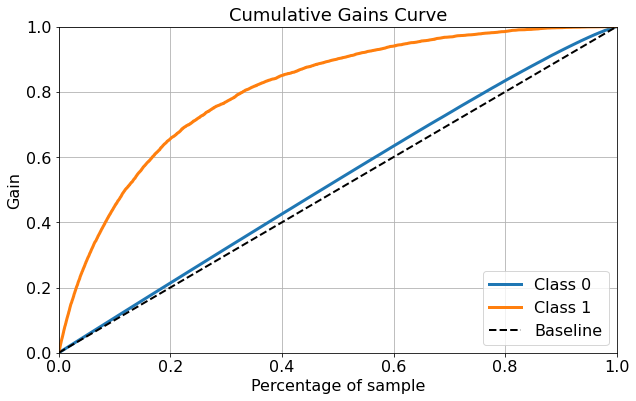

Lift Chart


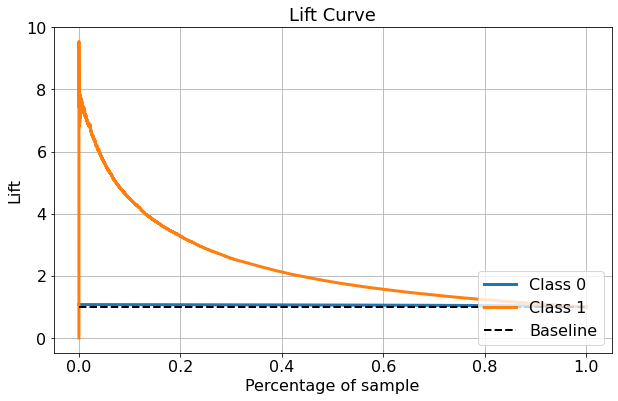

In [183]:

y_pred = xgb_model.predict(x_oot[top_features])
predicted_probas = xgb_model.predict_proba(x_oot[top_features])
model_metrics(y_pred, y_oot, predicted_probas)

In [184]:
x_oot.reset_index(drop=True,inplace=True)
y_oot.reset_index(drop=True,inplace=True)

df_oot = x_oot.copy()
df_oot['ns_flag'] = y_oot
df_oot['proba'] = xgb_model.predict_proba(x_oot[top_features])[:,1:].flatten()

# custom_bins = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
custom_bins = [0,0.2,0.4,0.6,0.8,1]

df_oot['proba'] = np.round(df_oot['proba'], 3)
df_oot['DecileRank']= pd.cut(df_oot['proba'], bins=custom_bins)
df_stats = pd.DataFrame(df_oot.groupby(by='DecileRank')['ns_flag'].mean())
df_stats['volume'] = df_oot.groupby(by='DecileRank')['ns_flag'].count()
df_stats['volume%'] = np.round((df_stats['volume'] / df_stats['volume'].sum()), 2)
df_stats

,ns_flag,volume,volume%
DecileRank,,,
"(0.0, 0.2]",0.011719,37120,0.44
"(0.2, 0.4]",0.043739,24555,0.29
"(0.4, 0.6]",0.115130,13602,0.16
"(0.6, 0.8]",0.260659,7834,0.09
"(0.8, 1.0]",0.479738,1678,0.02


In [185]:
x_oot.shape

(84789, 400)

In [186]:
# df_stats.to_csv(project_path+'rough.csv')

### Test Data

In [172]:
oot_df = x_test.copy()
y_oot = y_test.copy()

# Adding segment test data
segment_oot = app_level_data_oot.copy()
# oot_df = pd.merge(oot_df, segment_oot, on='application_id', how='inner')
x_oot = oot_df[raw_features]

# convert all string features to lowercase
string_features = ['email_domain',
 'purpose_of_account',
 'current_bank',
 'industry_category_name',
 'business_type',
 'business_address_city',
 'business_address_state',
 'website']+cat_columns+socure_reason_cols

for col in string_features:
    x_oot[col] = x_oot[col].str.lower()

In [173]:
x_oot = convert_nulls_to_one_format(df=x_oot)
df_impute = pd.read_pickle(project_path+'models/df_impute.pkl')
x_oot = fill_null_values(df_impute, x_oot)

x_oot = feature_engineering_app(df=x_oot)
x_oot = feature_engineering_alloy(df=x_oot, training=False)

# Removing reason code features as these are already encoded
x_oot.drop(columns=ida_reason_cols+socure_reason_cols, inplace=True)

# Encoding the categories
x_object_cols = x_oot[independent_features_alloy_tmp].select_dtypes(include=['object']).columns.to_list()
x_object_cols = x_object_cols+['industry_category_name']

x_object_onehot = pd.get_dummies(x_oot[x_object_cols]) # create dummies
x_object_onehot = x_object_onehot.astype('int')
x_oot = pd.concat([x_oot.drop(columns=x_object_cols), x_object_onehot], axis=1)
x_oot.columns= x_oot.columns.str.lower() # convert column names to lower case


# Filter the final independent features
train_cols = pd.read_pickle(project_path+'models/train_data_columns.pkl')['feature'].to_list()
df_tmp = pd.DataFrame(index=range(x_oot.shape[0]),columns=train_cols)
df_tmp = df_tmp.fillna(0)
df_tmp.update(x_oot)
x_oot = df_tmp.copy()
x_oot.shape

(37411, 400)

In [174]:
sum(y_oot), y_oot.shape, y_oot.mean(), y_oot[y_oot==0].shape[0]/y_oot.sum()

(2582, (37411,), 0.06901713399802198, 13.489155693261038)

Accuracy Score: 0.82 

Confusion Matrix:
        pred:0  pred:1
true:0   29257    5572
true:1    1099    1483 

False Positive Rate: 0.16
True Positive Rate: 0.57
AUC: 0.71 

Sensitivity: 0.57
Specificity: 0.84 

F1 Score: 0.31 

KS Score:
KstestResult(statistic=0.11956376466814567, pvalue=1.7980378208747115e-233) 

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.84      0.90     34829
           1       0.21      0.57      0.31      2582

    accuracy                           0.82     37411
   macro avg       0.59      0.71      0.60     37411
weighted avg       0.91      0.82      0.86     37411

Gain Chart


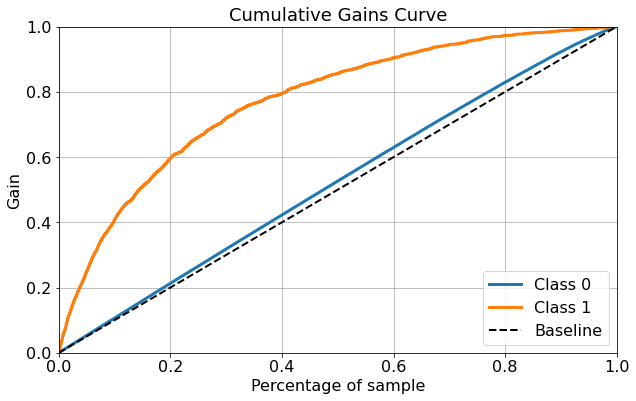

Lift Chart


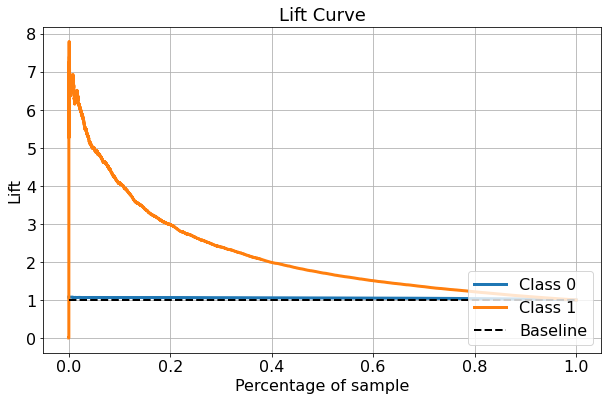

In [175]:
y_pred = xgb_model.predict(x_oot[top_features])
predicted_probas = xgb_model.predict_proba(x_oot[top_features])
model_metrics(y_pred, y_oot, predicted_probas)

In [176]:
x_oot.reset_index(drop=True,inplace=True)
y_oot.reset_index(drop=True,inplace=True)

df_oot = x_oot.copy()
df_oot['ns_flag'] = y_oot
df_oot['proba'] = xgb_model.predict_proba(x_oot[top_features])[:,1:].flatten()

# custom_bins = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
custom_bins = [0,0.2,0.4,0.6,0.8,1]
df_oot['proba'] = np.round(df_oot['proba'], 3)
df_oot['DecileRank']= pd.cut(df_oot['proba'], bins=custom_bins)
df_stats = pd.DataFrame(df_oot.groupby(by='DecileRank')['ns_flag'].mean())
df_stats['volume'] = df_oot.groupby(by='DecileRank')['ns_flag'].count()
df_stats['volume%'] = np.round((df_stats['volume'] / df_stats['volume'].sum()), 2)
df_stats

,ns_flag,volume,volume%
DecileRank,,,
"(0.0, 0.2]",0.017663,16305,0.44
"(0.2, 0.4]",0.047119,10760,0.29
"(0.4, 0.6]",0.105842,6094,0.16
"(0.6, 0.8]",0.236997,3557,0.10
"(0.8, 1.0]",0.430216,695,0.02


In [177]:
# df_stats.to_csv(project_path+'rough.csv')

In [166]:
df_raw_app[df_raw_app.total_deposit>=5000].shape[0], df_raw_app[df_raw_app.total_deposit>=10000].shape[0], df_raw_app[df_raw_app.total_deposit>=15000].shape[0]


(20028, 12413, 8654)

In [169]:
df_raw_app[df_raw_app.total_deposit>=5000].shape[0]/df_raw_app.shape[0], df_raw_app[df_raw_app.total_deposit>=10000].shape[0]/df_raw_app.shape[0], df_raw_app[df_raw_app.total_deposit>=15000].shape[0]/df_raw_app.shape[0]


(0.15707003372284525, 0.09734922751156772, 0.06786918673045252)

In [170]:
df_raw_app.shape

(127510, 163)

#### Plot Precision vs Recall

In [ ]:
def precision_recall_threshold_plot(y_true:np.array, yhat:np.array, thresholds:list):
    # keep probabilities for the positive outcome only
    precision_vals = []
    recall_vals = []
    for threshold in thresholds:
        yhat2 = []
        for val in yhat:
            if val>=threshold:
                yhat2.append(1)
            else:
                yhat2.append(0)
        yhat2 = np.array(yhat2)    
        pr = precision_score(y_true, yhat2, average='binary')
        rec = recall_score(y_true, yhat2, average='binary')
        roc_auc = roc_auc_score(y_true, yhat2, average=None)
        
        print('threshold:', threshold, ' predicted:', sum(yhat2), ' pred NS Rate:', np.round(yhat2.mean(),3),
             ' precision:', np.round(pr,3), ' recall:',np.round(rec,3), ' auc:',np.round(roc_auc,3))
        precision_vals.append(pr)
        recall_vals.append(rec)

    plt.figure(figsize=(5,5))
    # plot the roc curve for the model
    pyplot.plot(precision_vals, recall_vals, marker='.')
    # axis labels
    pyplot.xlabel('Precision')
    pyplot.ylabel('Recall')
    pyplot.grid(True)
    pyplot.show()


In [ ]:
# predict probabilities
# non-sp = 1
x_data = x_train.copy()
y_data = y_train.copy()
yhat = tuned_model.predict_proba(x_data[x_data.business_group==1])[:,1:].flatten()
y_true = y_data[y_data.index.isin(x_data[x_data.business_group==1].index.to_list())]
thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

print('Data Size:',y_true.shape[0],' True DS NS:',sum(y_true))    
precision_recall_threshold_plot(y_true=y_true, yhat=yhat, thresholds=thresholds)


In [ ]:
# predict probabilities
# non-sp = 1
x_data = x_test.copy()
y_data = y_test.copy()
yhat = tuned_model.predict_proba(x_data[x_data.business_group==1])[:,1:].flatten()
y_true = y_data[y_data.index.isin(x_data[x_data.business_group==1].index.to_list())]
thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
precision_recall_threshold_plot(y_true=y_true, yhat=yhat, thresholds=thresholds)

In [ ]:
# predict probabilities
# non-sp = 1
x_data = x_oot.copy()
y_data = y_oot.copy()
yhat = tuned_model.predict_proba(x_data[x_data.business_group==1])[:,1:].flatten()
y_true = y_data[y_data.index.isin(x_data[x_data.business_group==1].index.to_list())]
thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
precision_recall_threshold_plot(y_true=y_true, yhat=yhat, thresholds=thresholds)

In [ ]:
# predict probabilities
# sp = 0
x_data = x_train.copy()
y_data = y_train.copy()
yhat = tuned_model.predict_proba(x_data[x_data.business_group==0])[:,1:].flatten()
y_true = y_data[y_data.index.isin(x_data[x_data.business_group==0].index.to_list())]
thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
precision_recall_threshold_plot(y_true=y_true, yhat=yhat, thresholds=thresholds)

In [ ]:
# predict probabilities
# sp = 0
x_data = x_test.copy()
y_data = y_test.copy()
yhat = tuned_model.predict_proba(x_data[x_data.business_group==0])[:,1:].flatten()
y_true = y_data[y_data.index.isin(x_data[x_data.business_group==0].index.to_list())]
thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
precision_recall_threshold_plot(y_true=y_true, yhat=yhat, thresholds=thresholds)

In [ ]:
# predict probabilities
# sp = 0
x_data = x_oot.copy()
y_data = y_oot.copy()
yhat = tuned_model.predict_proba(x_data[x_data.business_group==0])[:,1:].flatten()
y_true = y_data[y_data.index.isin(x_data[x_data.business_group==0].index.to_list())]
thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
precision_recall_threshold_plot(y_true=y_true, yhat=yhat, thresholds=thresholds)

#### Feature Importance

In [ ]:
feature_imp_df = pd.DataFrame(zip(x_train.columns.to_list(), tuned_model.feature_importances_), columns=['feature','importance'])
feature_imp_df = feature_imp_df.sort_values(by=['importance'], ascending=False).reset_index(drop=True)
feature_imp_df[feature_imp_df.importance>=0.005]


In [ ]:
feature_imp_df[feature_imp_df.importance>0].shape

In [ ]:
# pd.DataFrame(x_train[raw_features_segment].corr()).to_csv(project_path+'segment_features_correlation.csv')

In [ ]:
plt.rcParams["figure.figsize"] = (20,40)
plot_importance(tuned_model, importance_type='total_gain')
plt.show()

#### Train rank ordering

In [ ]:
# train
x_train.reset_index(drop=True,inplace=True)
y_train.reset_index(drop=True,inplace=True)

df_train = x_train.copy()
df_train['ns_flag'] = y_train
df_train['proba'] = tuned_model.predict_proba(x_train)[:,1:].flatten()

# custom_bins = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
custom_bins = [0.0, 0.2, 0.4, 0.6, 1.0]
df_train['proba'] = np.round(df_train['proba'], 3)
df_train['DecileRank']= pd.cut(df_train['proba'], bins=custom_bins)
df_stats = pd.DataFrame(df_train.groupby(by='DecileRank')['ns_flag'].mean())
df_stats['volume'] = df_train.groupby(by='DecileRank')['ns_flag'].count()
df_stats['volume%'] = np.round((df_stats['volume'] / df_stats['volume'].sum())*100, 2)
df_stats

#### Test rank ordering

In [ ]:
# test
x_test.reset_index(drop=True,inplace=True)
y_test.reset_index(drop=True,inplace=True)

df_test = x_test.copy()
df_test['ns_flag'] = y_test
df_test['proba'] = tuned_model.predict_proba(x_test)[:,1:].flatten()

df_test['proba'] = np.round(df_test['proba'], 3)
df_test['DecileRank']= pd.cut(df_test['proba'], bins=custom_bins)
df_stats = pd.DataFrame(df_test.groupby(by='DecileRank')['ns_flag'].mean())
df_stats['volume'] = df_test.groupby(by='DecileRank')['ns_flag'].count()
df_stats['volume%'] = np.round((df_stats['volume'] / df_stats['volume'].sum())*100, 2)
df_stats

#### OOT rank ordering

In [ ]:
x_oot.reset_index(drop=True,inplace=True)
y_oot.reset_index(drop=True,inplace=True)

df_oot = x_oot.copy()
df_oot['ns_flag'] = y_oot
df_oot['proba'] = tuned_model.predict_proba(x_oot)[:,1:].flatten()

df_oot['proba'] = np.round(df_oot['proba'], 3)
df_oot['DecileRank']= pd.cut(df_oot['proba'], bins=custom_bins)
df_stats = pd.DataFrame(df_oot.groupby(by='DecileRank')['ns_flag'].mean())
df_stats['volume'] = df_oot.groupby(by='DecileRank')['ns_flag'].count()
df_stats['volume%'] = np.round((df_stats['volume'] / df_stats['volume'].sum())*100, 2)
df_stats

#### Cross Validation

In [ ]:
# cross_validation(tuned_model, x_train, y_train, scoring='roc_auc')

In [ ]:
# cross_validation(tuned_model, x_test, y_test, scoring='roc_auc')

In [ ]:
# tuned model - increasing class weight to 5 from 7
top_features = feature_imp_df[:25]['feature'].to_list()
x_tr = x_train[top_features]
x_te = x_test[top_features]
x_oo = x_oot[top_features]


tuned_model6 = XGBClassifier(max_depth=3, colsample_bytree=1 ,subsample=1 ,scale_pos_weight=7 ,learning_rate=0.1 
                            ,random_state=3)
tuned_model6.fit(x_tr, y_train)

print("TRAIN RESULTS:\n")
y_pred = tuned_model6.predict(x_tr)
predicted_probas = tuned_model6.predict_proba(x_tr)
model_metrics(y_pred, y_train, predicted_probas)

print("\n\nTEST RESULTS:\n")
y_pred = tuned_model6.predict(x_te)
predicted_probas = tuned_model6.predict_proba(x_te)
model_metrics(y_pred, y_test, predicted_probas)

print("\n\nOOT RESULTS:\n")
y_pred = tuned_model6.predict(x_oo)
predicted_probas = tuned_model6.predict_proba(x_oo)
model_metrics(y_pred, y_oot, predicted_probas)

In [ ]:
# tuned model - increasing class weight to 5 from 7
top_features = feature_imp_df[:25]['feature'].to_list()
x_tr = x_train[top_features]
x_te = x_test[top_features]
x_oo = x_oot[top_features]


tuned_model6 = XGBClassifier(max_depth=3, colsample_bytree=1 ,subsample=1 ,scale_pos_weight=6 ,learning_rate=0.1 
                            ,random_state=3)
tuned_model6.fit(x_tr, y_train)

print("TRAIN RESULTS:\n")
y_pred = tuned_model6.predict(x_tr)
predicted_probas = tuned_model6.predict_proba(x_tr)
model_metrics(y_pred, y_train, predicted_probas)

print("\n\nTEST RESULTS:\n")
y_pred = tuned_model6.predict(x_te)
predicted_probas = tuned_model6.predict_proba(x_te)
model_metrics(y_pred, y_test, predicted_probas)

print("\n\nOOT RESULTS:\n")
y_pred = tuned_model6.predict(x_oo)
predicted_probas = tuned_model6.predict_proba(x_oo)
model_metrics(y_pred, y_oot, predicted_probas)

In [ ]:
# tuned model - increasing class weight to 5 from 7
top_features = feature_imp_df[:25]['feature'].to_list()
x_tr = x_train[top_features]
x_te = x_test[top_features]
x_oo = x_oot[top_features]


tuned_model6 = XGBClassifier(max_depth=3, colsample_bytree=1 ,subsample=1 ,scale_pos_weight=5 ,learning_rate=0.1 
                            ,random_state=3)
tuned_model6.fit(x_tr, y_train)

print("TRAIN RESULTS:\n")
y_pred = tuned_model6.predict(x_tr)
predicted_probas = tuned_model6.predict_proba(x_tr)
model_metrics(y_pred, y_train, predicted_probas)

print("\n\nTEST RESULTS:\n")
y_pred = tuned_model6.predict(x_te)
predicted_probas = tuned_model6.predict_proba(x_te)
model_metrics(y_pred, y_test, predicted_probas)

print("\n\nOOT RESULTS:\n")
y_pred = tuned_model6.predict(x_oo)
predicted_probas = tuned_model6.predict_proba(x_oo)
model_metrics(y_pred, y_oot, predicted_probas)

In [ ]:
# tuned model - increasing class weight to 5 from 7
top_features = feature_imp_df[:25]['feature'].to_list()
x_tr = x_train[top_features]
x_te = x_test[top_features]
x_oo = x_oot[top_features]


tuned_model6 = XGBClassifier(max_depth=3, colsample_bytree=1 ,subsample=1 ,scale_pos_weight=7 ,learning_rate=0.1 
                            ,random_state=3, n_estimators=1000)
tuned_model6.fit(x_tr, y_train)

print("TRAIN RESULTS:\n")
y_pred = tuned_model6.predict(x_tr)
predicted_probas = tuned_model6.predict_proba(x_tr)
model_metrics(y_pred, y_train, predicted_probas)

print("\n\nTEST RESULTS:\n")
y_pred = tuned_model6.predict(x_te)
predicted_probas = tuned_model6.predict_proba(x_te)
model_metrics(y_pred, y_test, predicted_probas)

print("\n\nOOT RESULTS:\n")
y_pred = tuned_model6.predict(x_oo)
predicted_probas = tuned_model6.predict_proba(x_oo)
model_metrics(y_pred, y_oot, predicted_probas)

##### PSI

In [ ]:
q = SQLQuery('snowflake')

In [ ]:
df_score_v1 = q("""
                select application_id,
                 pred_prob
          from "PROD_DB"."DATA"."APPLICATIONS"
          where date(application_complete_datetime) between '2022-01-01' and '2023-01-31'
""")

In [ ]:
prob_tr = tuned_model6.predict_proba(x_tr)[:,1:].flatten()
prob_te = tuned_model6.predict_proba(x_te)[:,1:].flatten()
prob_oo = tuned_model6.predict_proba(x_oo)[:,1:].flatten()
prob_v2 = np.concatenate([prob_oo,prob_te,prob_tr])

In [ ]:
psi_score, psi_df = novo_ml_metrics.psi_equal_frequency(actual=df_score_v1.pred_prob.values, expected=prob_v2, 
                                                        plot=True)
print(psi_score)


In [ ]:
psi_score, psi_df = novo_ml_metrics.psi_equal_width(actual=df_score_v1.pred_prob.values, expected=prob_v2, 
                                                        plot=True)
print(psi_score)


#### Feature elimination

In [ ]:
# tuned model
tuned_model_final = XGBClassifier(max_depth=3, colsample_bytree=1 ,subsample=1 ,scale_pos_weight=7 ,learning_rate=0.1 
                            ,random_state=3)

In [ ]:
max_features = 398
num_features_to_remove = len(independent_features) - max_features

for i in range(0, num_features_to_remove):
    # train the model
    x_train = x_train[independent_features]
    tuned_model_final.fit(x_train, y_train)
    if (len(independent_features)) == max_features:
        break
    # get feature importance
    imp_df = pd.DataFrame(tuned_model_final.get_booster().get_score(importance_type='total_gain').items(), columns=['feature', 'importance'])
    # remove the least important feature
    feature_to_remove = imp_df.sort_values(by='importance', ascending=False).iloc[-1]['feature']
    print('feature removed:', feature_to_remove)
    independent_features.remove(feature_to_remove)
print('final features:', independent_features)

In [ ]:
print("TRAIN RESULTS:\n")
y_pred = tuned_model_final.predict(x_train)
predicted_probas = tuned_model_final.predict_proba(x_train)
model_metrics(y_pred, y_train, predicted_probas)

print("\n\nTEST RESULTS:\n")
y_pred = tuned_model_final.predict(x_test)
predicted_probas = tuned_model_final.predict_proba(x_test)
model_metrics(y_pred, y_test, predicted_probas)

print("\n\nOOT RESULTS:\n")
y_pred = tuned_model_final.predict(x_oot)
predicted_probas = tuned_model_final.predict_proba(x_oot)
model_metrics(y_pred, y_oot, predicted_probas)

#### Hyperparameter tuning

In [ ]:
y_train.shape, y_test.shape

In [ ]:
t.shape, sum(t), t[84554+36639]

In [ ]:
# y_test[y_test==1]

In [ ]:
estimator = XGBClassifier(random_state=3)

parameters = {
    'max_depth': range (2, 5, 1),
    'learning_rate': [0.05, 0.1, 0.15],
#     'subsample': [0.8, 1],
#     'colsample_bytree' : [0.8, 1],
    'scale_pos_weight' : range(4, 8, 1)
}

x_train_test = pd.concat([x_train, x_test], axis=0).reset_index(drop=True)
y_train_test = np.concatenate([y_train, y_test], axis=0)

best_model = tune_hyperparameters(x_train_test, y_train_test, estimator, parameters, metric='roc_auc', cv_folds=3)

# best_model.save_model("best_model.json")

In [ ]:
# # best_model parameters

# XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#               colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
#               gamma=0, gpu_id=-1, importance_type=None,
#               interaction_constraints='', learning_rate=0.1, max_delta_step=0,
#               max_depth=4, min_child_weight=1, missing=nan,
#               monotone_constraints='()', n_estimators=100, n_jobs=8,
#               num_parallel_tree=1, predictor='auto', random_state=3,
#               reg_alpha=0, reg_lambda=1, scale_pos_weight=6, subsample=1,
#               tree_method='exact', validate_parameters=1, verbosity=None)

best_model

In [ ]:
print("TRAIN RESULTS:\n")
y_pred = best_model.predict(x_train)
predicted_probas = best_model.predict_proba(x_train)
model_metrics(y_pred, y_train, predicted_probas)

print("\n\nTEST RESULTS:\n")
y_pred = best_model.predict(x_test)
predicted_probas = best_model.predict_proba(x_test)
model_metrics(y_pred, y_test, predicted_probas)

print("\n\nOOT RESULTS:\n")
y_pred = best_model.predict(x_oot)
predicted_probas = best_model.predict_proba(x_oot)
model_metrics(y_pred, y_oot, predicted_probas)

In [ ]:
best_model2 = XGBClassifier(random_state=3, max_depth=4, scale_pos_weight=6, learning_rate=0.1)
best_model2.fit(x_train, y_train)

print("TRAIN RESULTS:\n")
y_pred = best_model2.predict(x_train)
predicted_probas = best_model2.predict_proba(x_train)
model_metrics(y_pred, y_train, predicted_probas)

print("\n\nTEST RESULTS:\n")
y_pred = best_model2.predict(x_test)
predicted_probas = best_model2.predict_proba(x_test)
model_metrics(y_pred, y_test, predicted_probas)

print("\n\nOOT RESULTS:\n")
y_pred = best_model2.predict(x_oot)
predicted_probas = best_model2.predict_proba(x_oot)
model_metrics(y_pred, y_oot, predicted_probas)

In [ ]:
feature_imp_df = pd.DataFrame(zip(x_train.columns.to_list(), best_model2.feature_importances_), columns=['feature','importance'])
feature_imp_df = feature_imp_df.sort_values(by=['importance'], ascending=False).reset_index(drop=True)
feature_imp_df[feature_imp_df.importance>=0.005]


In [ ]:
# tuned model - increasing class weight to 5 from 7
top_features = feature_imp_df[:25]['feature'].to_list()
x_tr = x_train[top_features]
x_te = x_test[top_features]
x_oo = x_oot[top_features]


tuned_model6 = XGBClassifier(random_state=3, max_depth=4, scale_pos_weight=6, learning_rate=0.1)
tuned_model6.fit(x_tr, y_train)

print("TRAIN RESULTS:\n")
y_pred = tuned_model6.predict(x_tr)
predicted_probas = tuned_model6.predict_proba(x_tr)
model_metrics(y_pred, y_train, predicted_probas)

print("\n\nTEST RESULTS:\n")
y_pred = tuned_model6.predict(x_te)
predicted_probas = tuned_model6.predict_proba(x_te)
model_metrics(y_pred, y_test, predicted_probas)

print("\n\nOOT RESULTS:\n")
y_pred = tuned_model6.predict(x_oo)
predicted_probas = tuned_model6.predict_proba(x_oo)
model_metrics(y_pred, y_oot, predicted_probas)

##### Increasing class weight increasing increases recall and decreases precision and otherwise

#### Save model object

In [ ]:
# file_name = "nsql_model_v1.pkl"
# path = project_path + 'models/'
# pickle.dump(tuned_model, open(path + file_name, "wb"))

ADHOC

In [86]:
# test = pd.read_excel('../../../../../slack_downloads/Account Closures Jun 1.xlsx')

# from sqlalchemy.types import NVARCHAR
# # write the new applications to db
# test.to_sql(name='testing_fraud_scores',
#                  con=q.engine, 
#                  schema='prod_db.adhoc',
#                  if_exists='append', 
#                  index=False, 
#                  chunksize=16000, 
#                  method='multi',
#                  dtype={col_name: NVARCHAR for col_name in test})

In [87]:
# test.shape

(115, 4)